# Instrumental folder generation for CMWP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.xrd_tools import getReflections
from lmfit import fit_report
from lmfit.models import LinearModel,  PseudoVoigtModel, Pearson7Model, GaussianModel, SkewedVoigtModel, SkewedGaussianModel
from scipy.interpolate import CubicSpline

## Set paramaters

In [2]:
a = 4.15691                   # a lattice paramater of the calibrant in angstrom             
wavelength = 0.1850510408901599         # Wavelength in angstrom

inputfile = '/mnt/manchester_rds/202011_DESY/raw/close_detector/LaB6.dat'
outfolder = '/home/rhys/Documents/CMWP-211102/2020_11_DESY/instr/'

In [3]:
x_2theta, y = np.loadtxt(inputfile, unpack=True)

y=y+1000

x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(x_2theta)/2)) / wavelength

In [4]:
peak_name, peak_pos = getReflections(crystalType='cubic', outputType='2theta', a=a, wavelength=wavelength, printReflections=False)
_, peak_pos_k = getReflections(crystalType='cubic', outputType='k', a=a, wavelength=wavelength, printReflections=False)
peak_pos_k_nm = peak_pos_k*10


baseline = (peak_pos_k_nm[:-1]+peak_pos_k_nm[1:])/2
baseline = np.append(x_k_nm[15], baseline)

## Subtract background

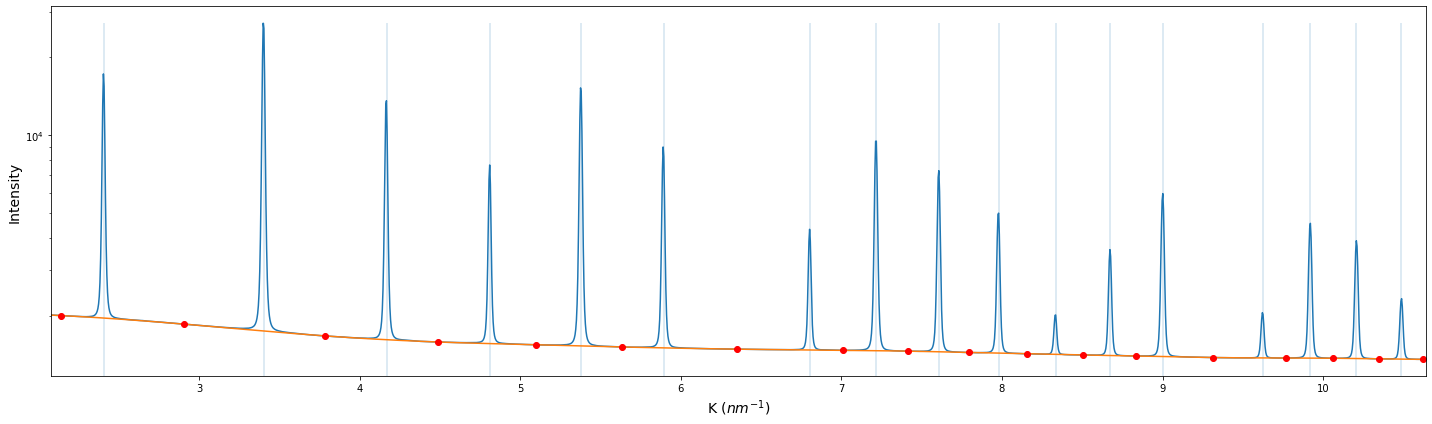

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')

plt.tight_layout()
baseline_int=[]

for j in baseline:
    num_index =np.argmin(np.abs(x_k_nm-j))
    baseline_int.append(np.mean(y[num_index-10:num_index+10]))
        
cs = CubicSpline(baseline, baseline_int)

ax.plot(x_k_nm, cs(x_k_nm))
ax.plot(baseline, baseline_int, c='r', marker='o', linewidth=0)

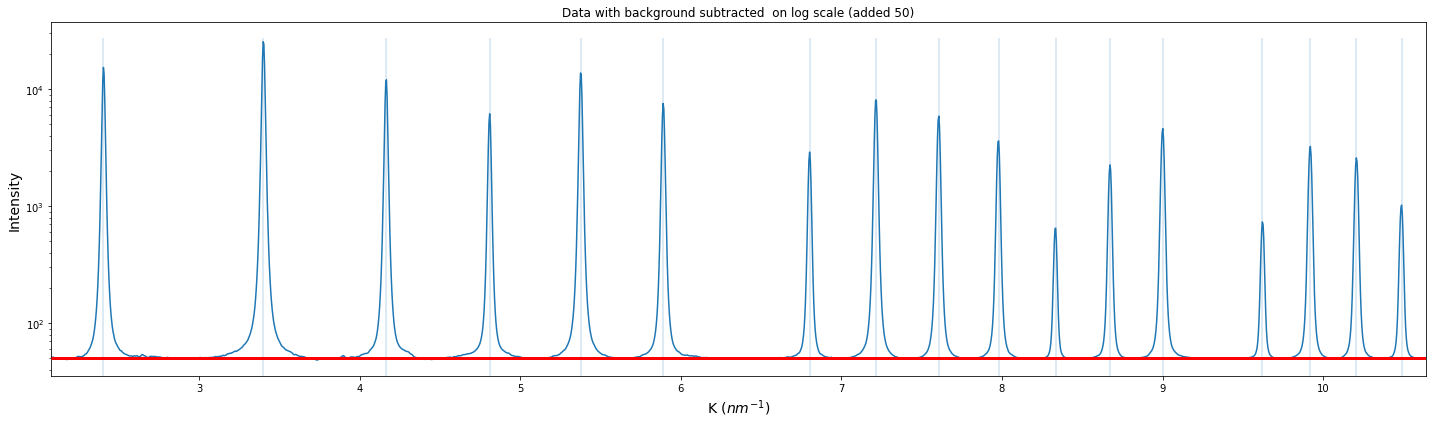

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

y_nobck = y-cs(x_k_nm)

ax.plot(x_k_nm, y_nobck+50, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')
ax.hlines([50], colors='r', linewidth=3, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)
plt.title('Data with background subtracted  on log scale (added 50)')

actual_peaks = []

for i, peak in enumerate(peak_pos_k_nm):
    if np.min(x_k_nm) < peak < np.max(x_k_nm):
        
        searchrange = 10
        
        elem = np.abs(x_k_nm-peak).argmin()
                 
        peak_index = np.argmax(y_nobck[elem-searchrange:elem+searchrange])+elem-searchrange
        peak_x = x_k_nm[peak_index]
        actual_peaks.append(peak_x)
        
ax.vlines(actual_peaks, ymin=0, ymax=np.max(y), alpha=0.2)

plt.tight_layout()


## Fit peaks

In [7]:
models = []; pars = []; prefixes = [];

for i, peak in enumerate(actual_peaks):
        
    search = 20 + i*10

    elem = np.abs(x_k_nm-peak).argmin()

    xvals = x_k_nm[elem-search:elem+search]
    yvals = y_nobck[elem-search:elem+search]
    
    prefix = 'g'+str(i)+'_'
    prefixes.append(prefix)
    
    mod = PseudoVoigtModel(prefix=prefix)
    #mod = GaussianModel(prefix=prefix)
    #mod = Pearson7Model(prefix=prefix, nan_policy='omit')
    models.append(mod)
    
    par = mod.make_params()

    par[prefix+'center'].set(value=peak, min=peak-0.05, max=peak+0.05)
    par[prefix+'sigma'].set(value=0.005, min=0.001, max=0.2)
    par[prefix+'height'].set(value=(np.max(yvals)-np.min(yvals)), min=(np.max(yvals)-np.min(yvals))-100, max=(np.max(yvals)-np.min(yvals))+100)
    pars.append(par)

models = np.sum(models)
pars = np.sum(pars)
    
init = models.eval(pars, x=x_k_nm)

### WEIGHT METHOD NONE SQRT OR INVSQRT
weight = 'sqrt'

if weight == 'none':
    out = models.fit(y_nobck+2, pars, x=x_k_nm)
elif weight == 'invsqrt':
    out = models.fit(y_nobck+2, pars, weights=1/np.sqrt(np.abs(y_nobck)+1), x=x_k_nm)
elif weight == 'sqrt':
    out = models.fit(y_nobck+2, pars, weights=np.sqrt(np.abs(y_nobck)+1), x=x_k_nm)


/home/rhys/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: FutureWarning: The input object of type 'Parameters' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Parameters', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rhys/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwar

In [8]:
#out.result

(1, 38964.82192200633)

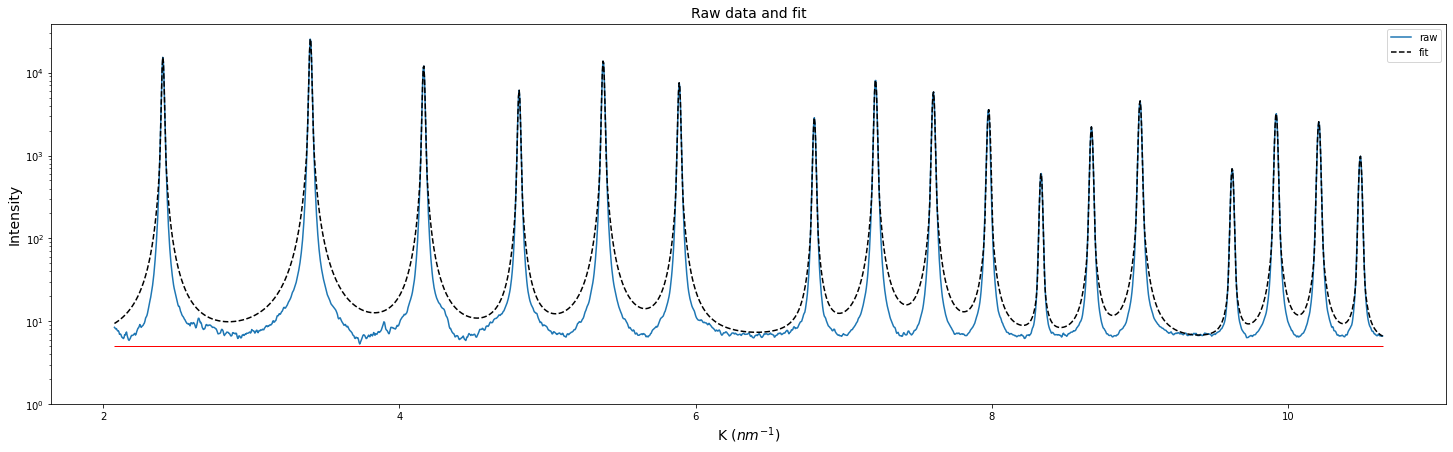

In [9]:
elevate = 5
fig, ax = plt.subplots(1,1, figsize=(25, 7))
ax.plot(x_k_nm, y_nobck+elevate+2, label='raw')
ax.plot(x_k_nm, np.sum([out.eval_components(x=x_k_nm)[prefix] for prefix in prefixes], axis=0)+elevate, 'k--', label='fit')
ax.legend()

ax.set_title('Raw data and fit', fontsize=14)
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);

ax.hlines([elevate], colors='r', linewidth=1, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)

ax.set_yscale('log')
ax.set_ylim(1)

## Show individual components, normalised by height

In [110]:
print(out.result.params[prefix+'center'].value)

10.487667021589889


In [113]:
# Expand d range to catch peaks that are clipping on edges

gap=x_2theta[1]-x_2theta[0]
new_x_2theta = np.arange(np.min(x_2theta)-2, np.max(x_2theta)+2, gap)
new_x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(new_x_2theta)/2)) / wavelength

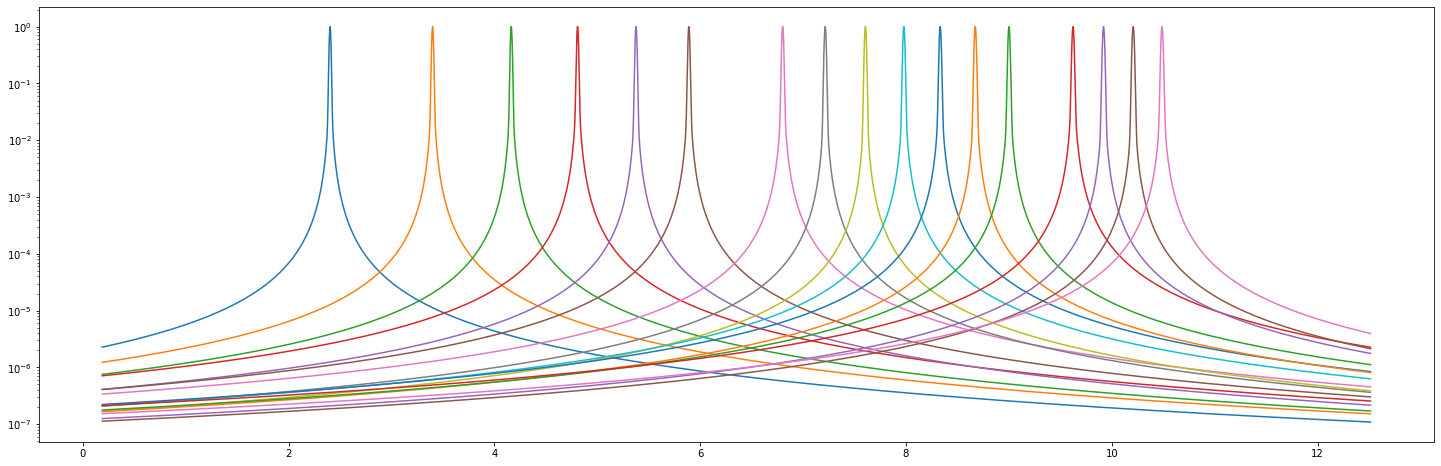

In [125]:
maxheight = np.max([out.eval_components(x=x_k_nm)[prefix] for prefix in prefixes])
fig, ax = plt.subplots(figsize=(25,8))
for prefix in prefixes:
    scale_height = 1/np.max(out.eval_components(x=new_x_k_nm)[prefix])
    ax.plot(new_x_k_nm, out.eval_components(x=new_x_k_nm)[prefix]*scale_height, label='fit')
    #print(out.params[prefix + 'sigma'].value)
plt.yscale('log')
#plt.ylim(-20, 1000)

## Save instrumental folder

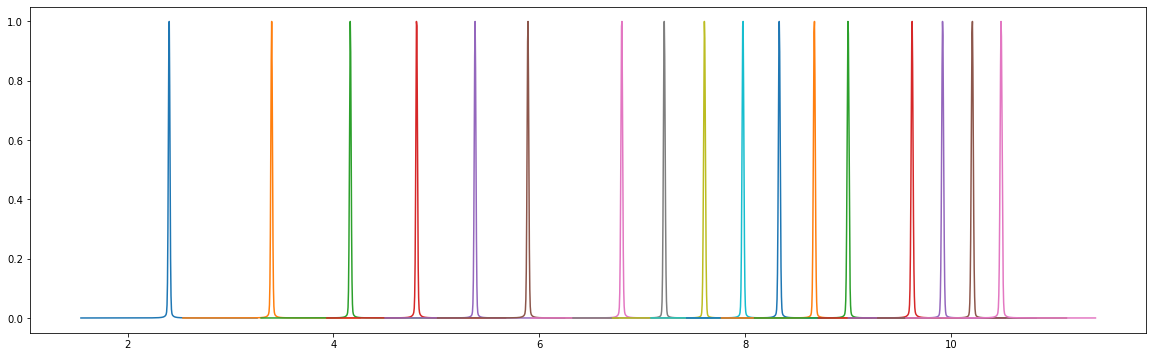

In [126]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
plt.figure(figsize=(20,6))

for i, prefix in enumerate(prefixes):
    
    search = 200 + i
    
    y_out = out.eval_components(x=new_x_k_nm)[prefix]
    
    elem = y_out.argmax()

    xvals = new_x_k_nm[elem-search:elem+search]
    yvals = y_out[elem-search:elem+search]/np.max(y_out[elem-search:elem+search])

    plt.plot(xvals, yvals, label='fit')
    
    xvals = xvals - out.result.params[prefix+'center'].value

    peak_k = new_x_k_nm[elem]
    
    peak_2th = np.rad2deg(np.arcsin((peak_k * wavelength) / 20))*2
    
    np.savetxt(outfolder + '{0:.3f}'.format(peak_2th), np.array([xvals, yvals]).T, fmt = ('%1.8f'))